# Comprehensive EDA notebook for On-Device Machine Learning for vibration based predictive maintainance of industrial induction motors using MEMS sensors.

### imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob as glob
import warnings

from scipy.signal import welch, spectrogram
from scipy.fft import rfft, rfftfreq
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from sklearn.manifold import TSNE

### configuration and file loading

In [50]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12,4)

filemap = {
    'motor_off': 'motor_off.xlsx',
    'motor_on': 'motor_on.xlsx',
    'motor_on_nofan': 'motor_on_nofan.xlsx',
    'motor_on_badfan': 'motor_on_badfan.xlsx'
}
data_columns = ['ax','ay','az','gx','gy','gz']
label_column = 'class_label'
time_column = 'timestamp'
fs = 40.0 #nominal sampling frequency

In [10]:
frames = []

for label,fname in filemap.items():
    df = pd.read_excel(fname)
    frames.append(df)

df = pd.concat(frames)
print ('combined shape:', df.shape)

combined shape: (144000, 8)


In [16]:
df.head()

,timestamp,ax,ay,az,gx,gy,gz,class_label
0,2025-10-09 13:43:26,0.040748,-0.047336,1.006988,-0.7350,-0.0350,-0.3500,0
1,2025-10-09 13:43:26,0.042700,-0.050996,1.008696,-0.7525,-0.0175,-0.2975,0
2,2025-10-09 13:43:26,0.041724,-0.050996,1.009428,-0.7000,-0.1575,-0.2975,0
3,2025-10-09 13:43:26,0.040992,-0.049776,1.008696,-0.6475,-0.1750,-0.2275,0
4,2025-10-09 13:43:26,0.038064,-0.051972,1.008208,-0.5950,-0.1750,-0.3500,0


In [24]:
print('------------- dataframe information ---------------')
df.info()

------------- dataframe information ---------------
<class 'pandas.core.frame.DataFrame'>
Index: 144000 entries, 0 to 35999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   timestamp    144000 non-null  datetime64[ns]
 1   ax           144000 non-null  float64       
 2   ay           144000 non-null  float64       
 3   az           144000 non-null  float64       
 4   gx           144000 non-null  float64       
 5   gy           144000 non-null  float64       
 6   gz           144000 non-null  float64       
 7   class_label  144000 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 9.9 MB


In [34]:
print('------------- class distribution ---------------')
print(df[label_column].value_counts())

------------- class distribution ---------------
class_label
0    36000
1    36000
2    36000
3    36000
Name: count, dtype: int64


In [48]:
print('------------- summary statistic ---------------')
print(df[data_columns].describe().T)

------------- summary statistic ---------------
       count      mean       std        min       25%       50%       75%  \
ax  144000.0  0.084532  0.183301  -0.371612 -0.005856  0.034892  0.134444   
ay  144000.0 -0.343062  0.476303  -1.473516 -0.883768 -0.080764 -0.003416   
az  144000.0  0.663798  0.561555  -0.972096  0.270047  0.922320  1.015284   
gx  144000.0 -0.691159  9.248581 -43.207500 -2.380000 -0.682500  0.857500   
gy  144000.0 -0.088613  6.172046 -29.242500 -0.577500 -0.087500  0.525000   
gz  144000.0 -0.256149  2.235907  -9.030000 -0.700000 -0.297500  0.087500   

          max  
ax   1.093120  
ay   0.535092  
az   2.081564  
gx  41.877500  
gy  32.637500  
gz  10.010000  


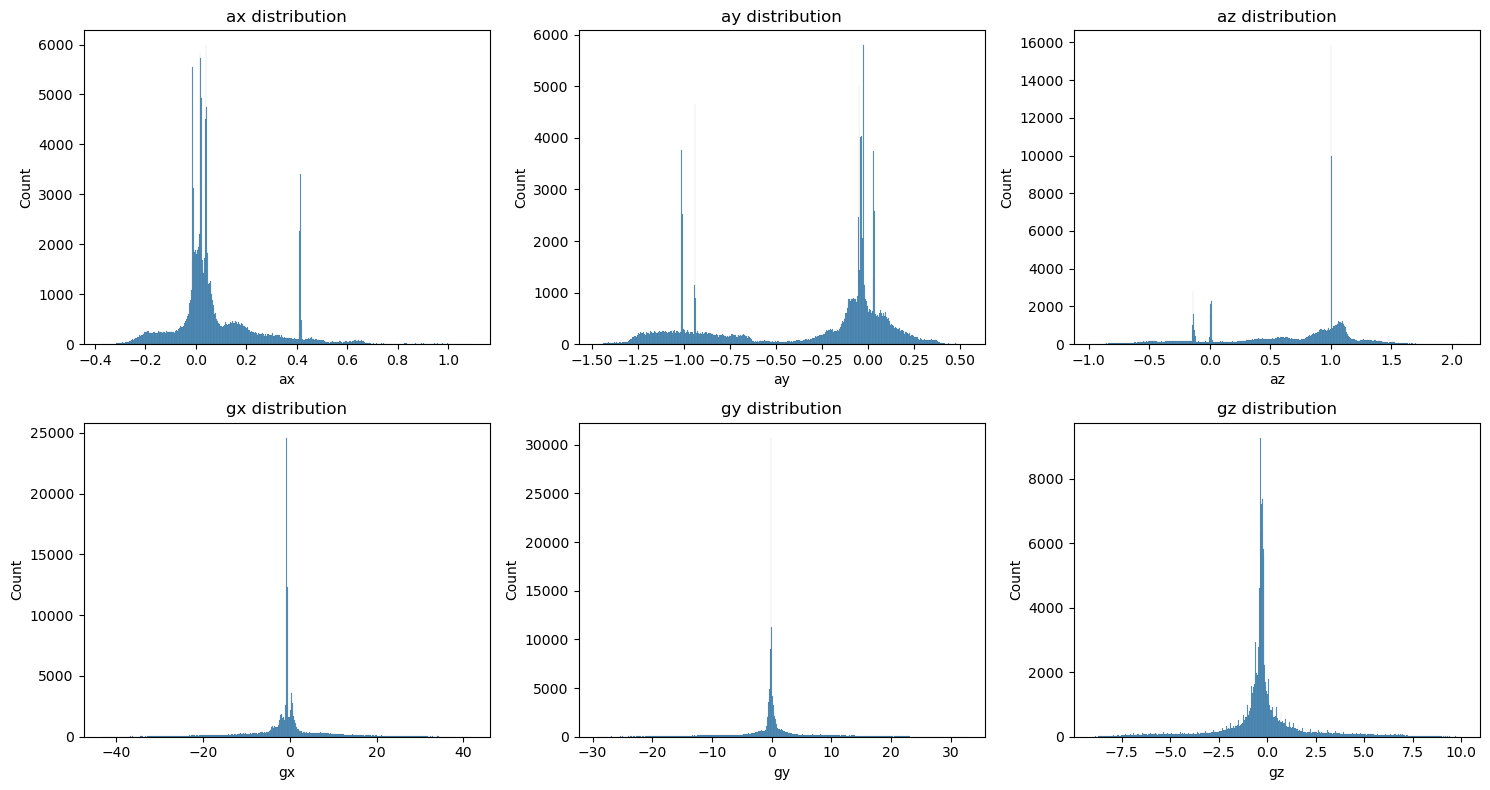

In [58]:
#histogram
fig, axes = plt.subplots(2, 3, figsize = (15,8))

for i, col in enumerate(data_columns):
    ax = axes.flat[i]
    sns.histplot(df[col], bins = 500, ax=ax)
    ax.set_title(f'{col} distribution')

plt.tight_layout()

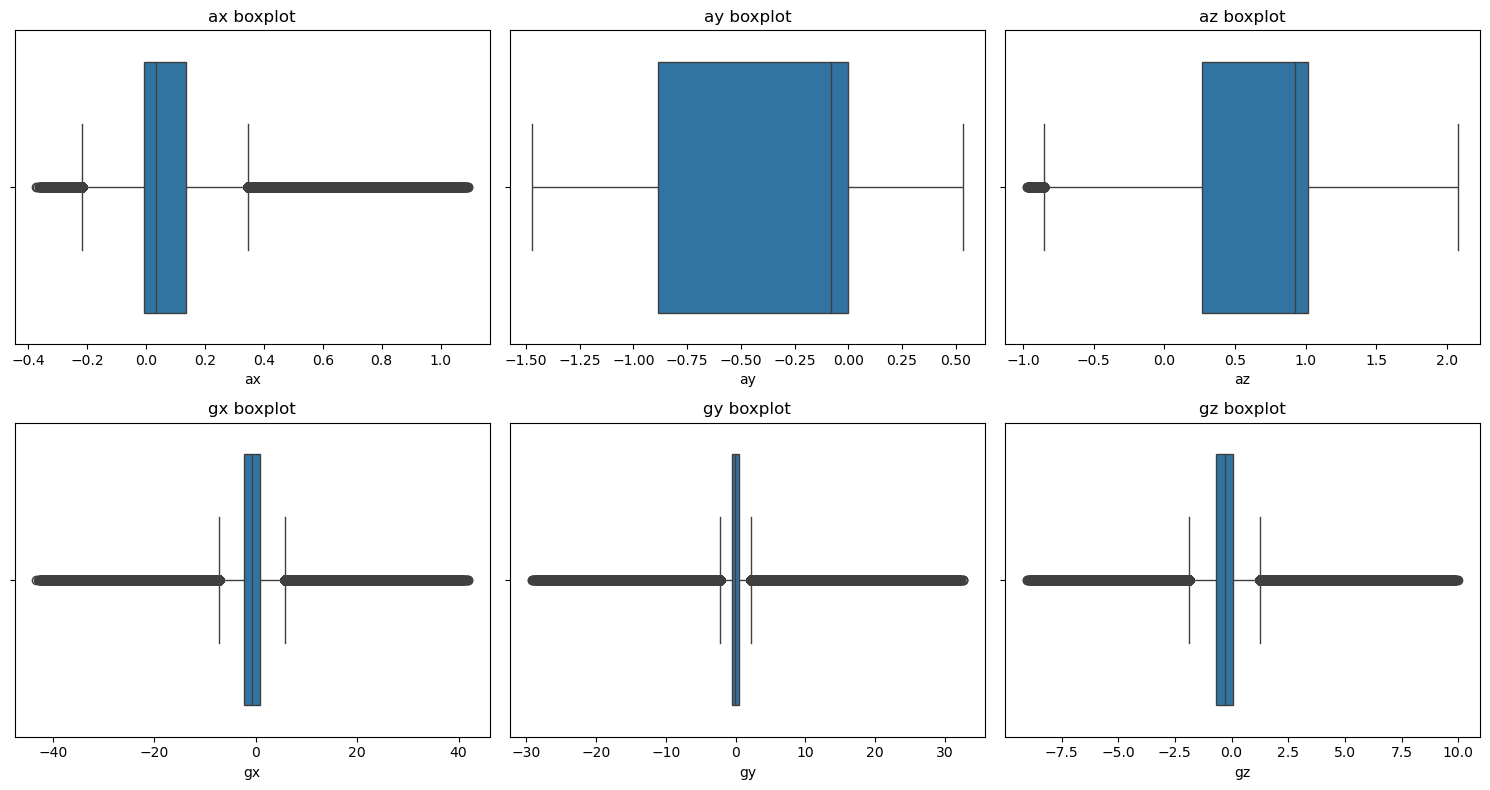

In [60]:
#boxplot
fig, axes = plt.subplots(2, 3, figsize = (15,8))

for i, col in enumerate(data_columns):
    ax = axes.flat[i]
    sns.boxplot(x = df[col], ax = ax)
    ax.set_title(f'{col} boxplot')

plt.tight_layout()

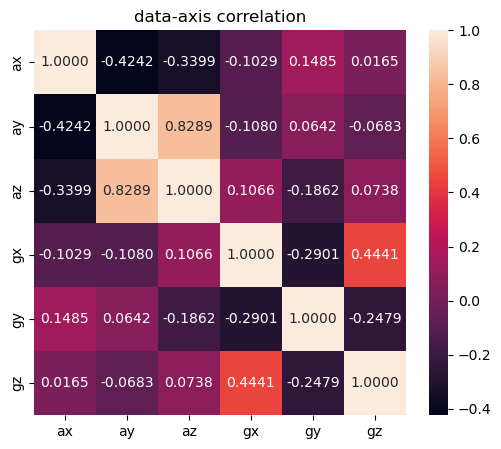

In [81]:
plt.figure(figsize=(6,5))

sns.heatmap(df[data_columns].corr(), annot=True, fmt='.4f')
plt.title('data-axis correlation')
plt.show()

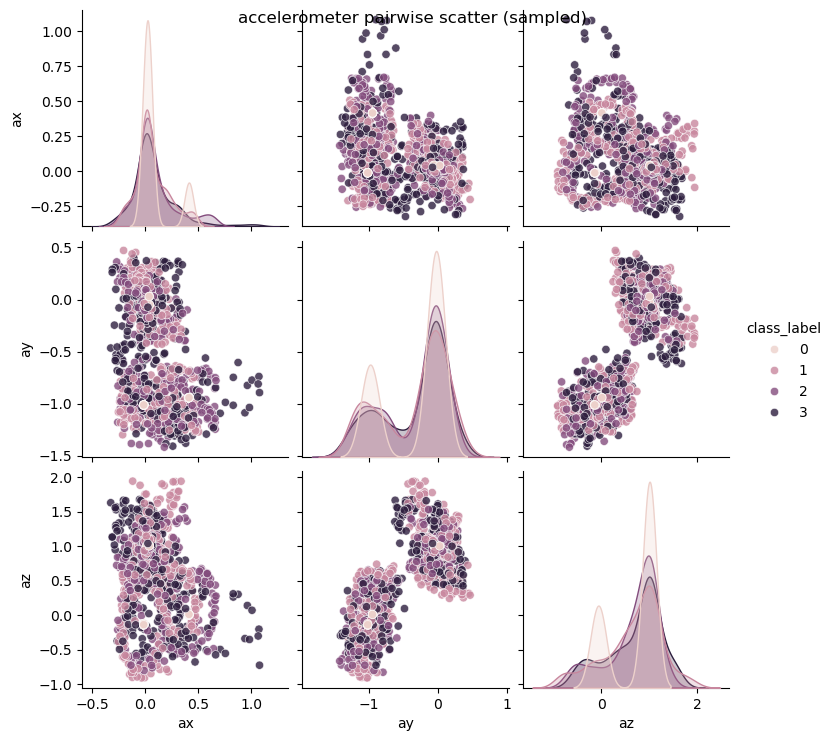

In [89]:
# Scatter pairs for accelerometer axes
sns.pairplot(df.sample(min(2000,len(df))), vars = ['ax','ay','az'], hue = label_column, plot_kws = {'alpha':0.8})
plt.suptitle('accelerometer pairwise scatter (sampled)')
plt.show()

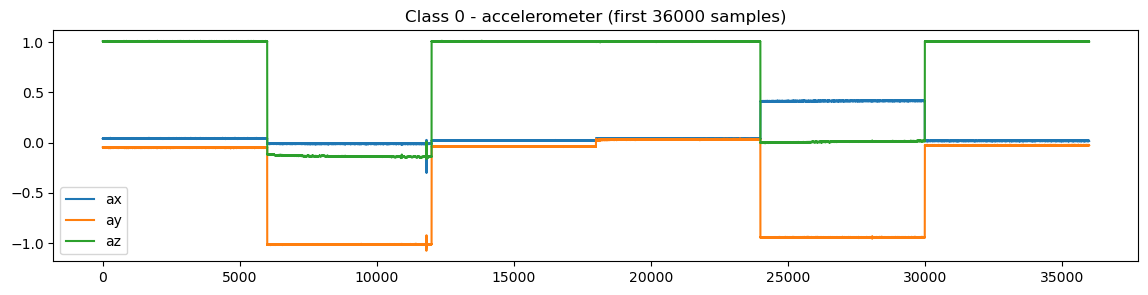

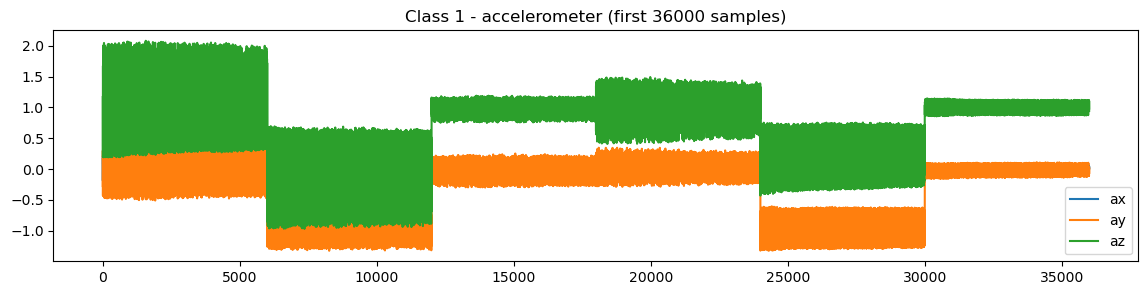

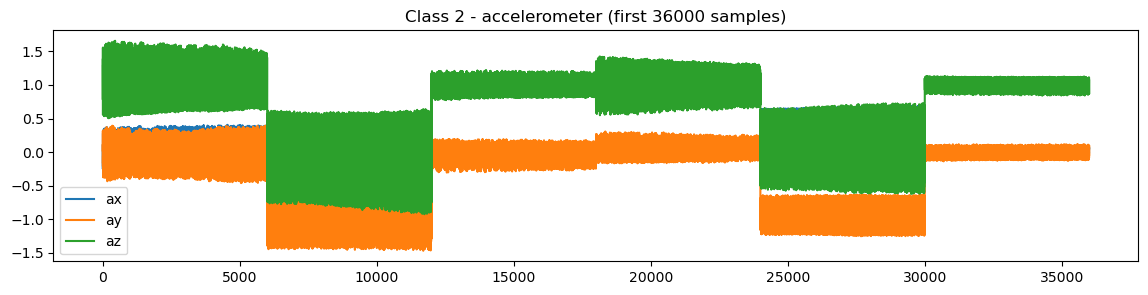

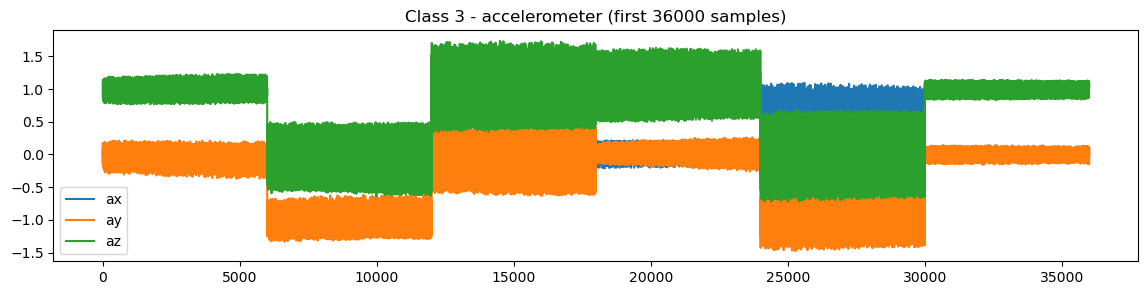

In [103]:
# first N samples for each class to visually compare waveforms
N = 36000

unique_labels = sorted(df[label_column].unique())

for lab in unique_labels:
    sub = df[df[label_column] == lab].head(N)
    plt.figure(figsize = (14,3))
    plt.plot(sub[data_columns[:3]].values)
    plt.legend(data_columns[:3])
    plt.title(f'Class {lab} - accelerometer (first {len(sub)} samples)')
    plt.show()

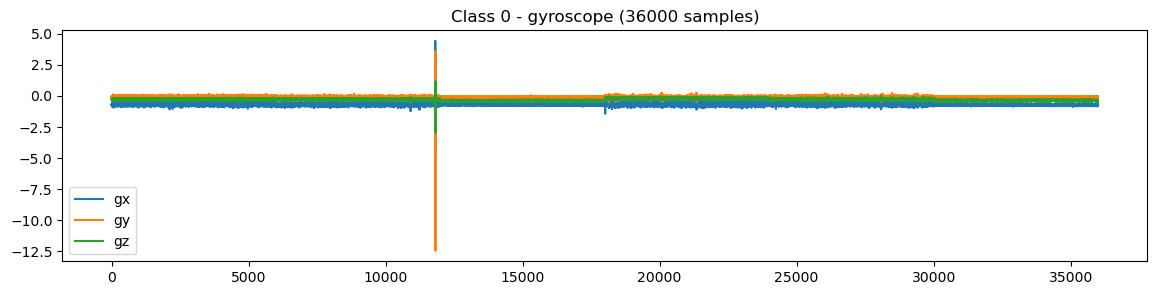

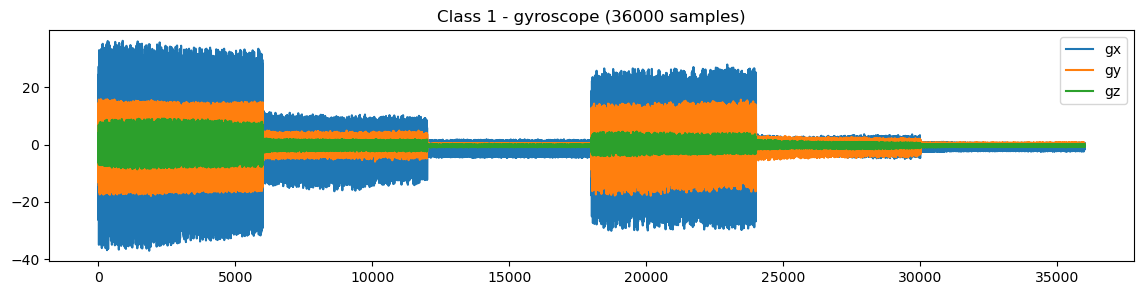

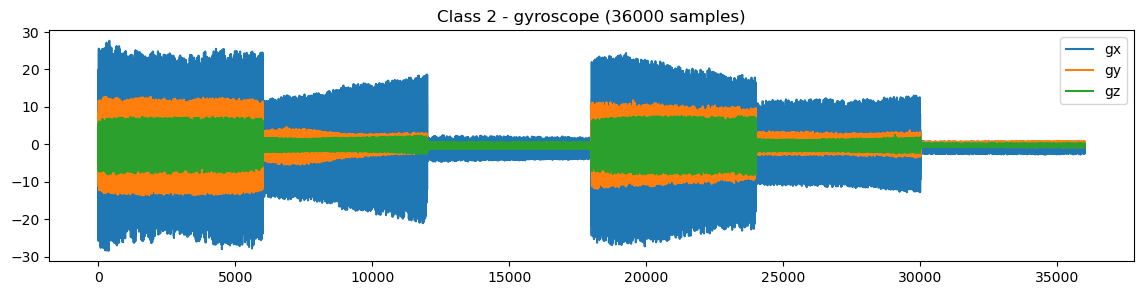

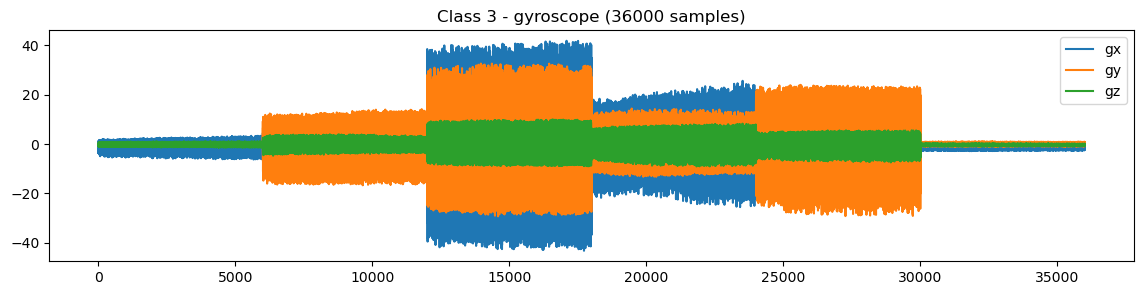

In [101]:
# first N samples for each class to visually compare waveforms
N = 36000

unique_labels = sorted(df[label_column].unique())

for lab in unique_labels:
    sub = df[df[label_column] == lab].head(N)
    plt.figure(figsize = (14,3))
    plt.plot(sub[data_columns[3:7]].values)
    plt.legend(data_columns[3:7])
    plt.title(f'Class {lab} - gyroscope ({len(sub)} samples)')
    plt.show()

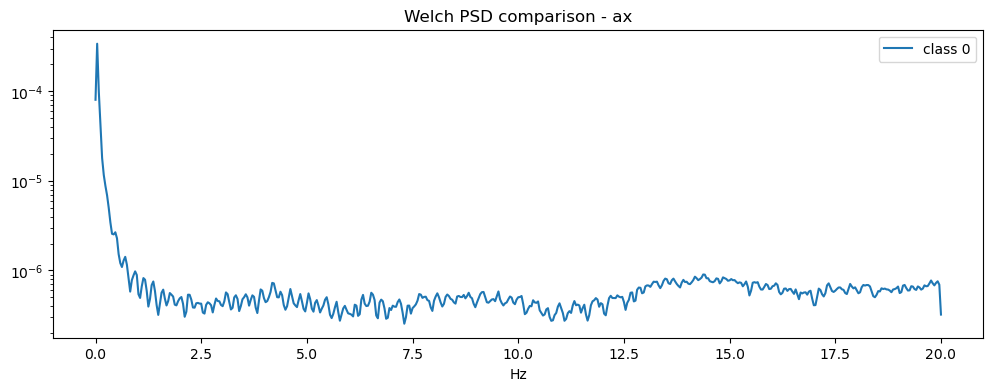

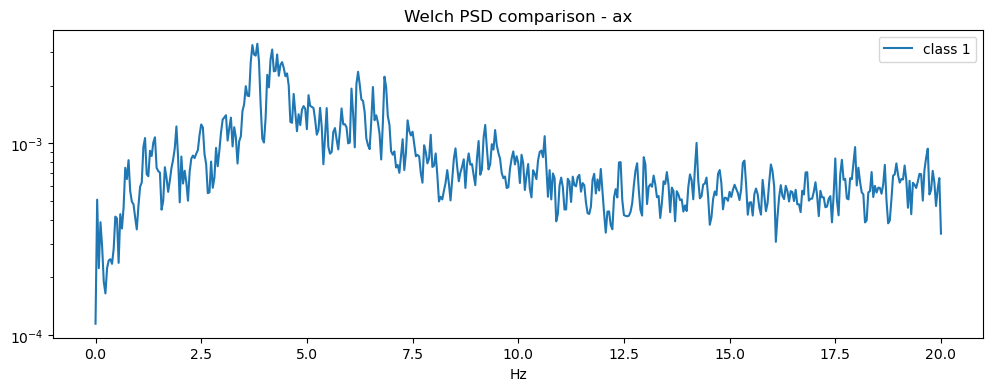

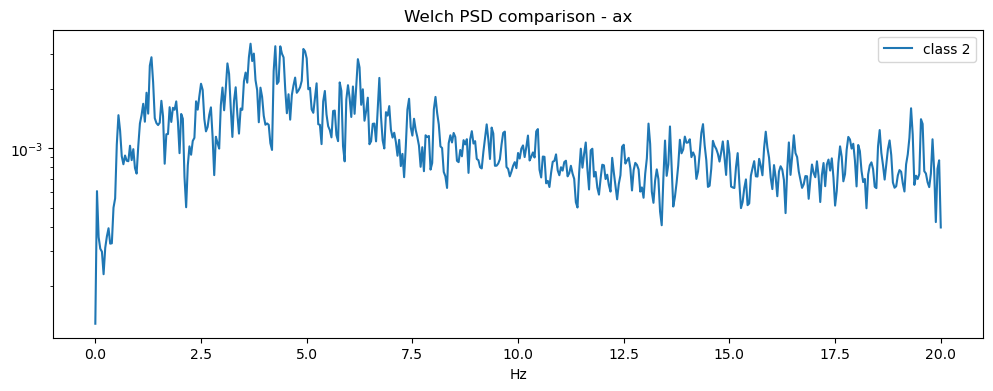

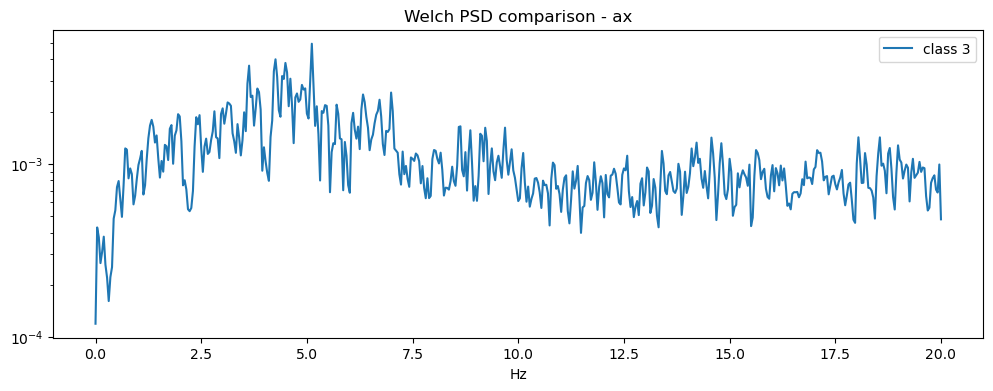

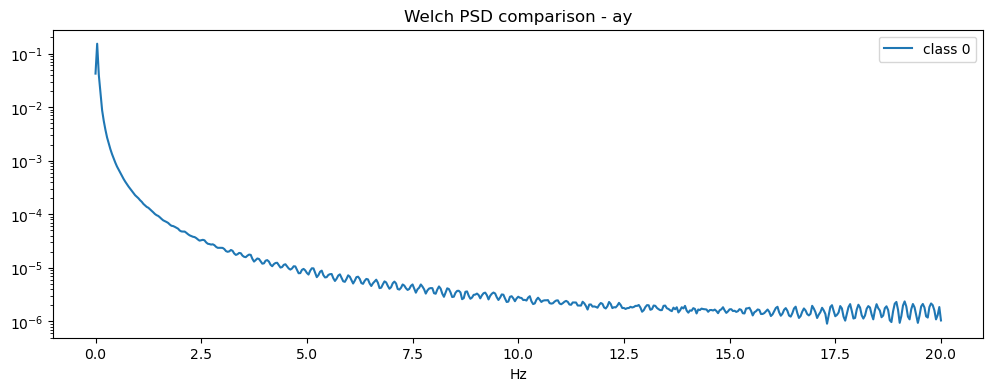

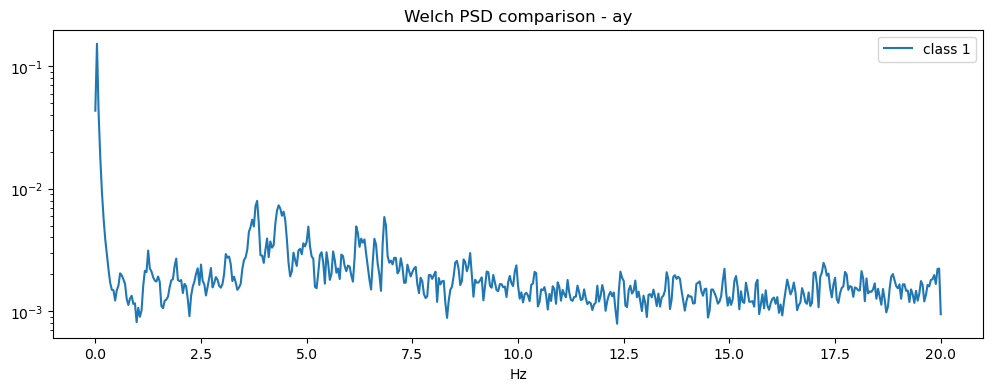

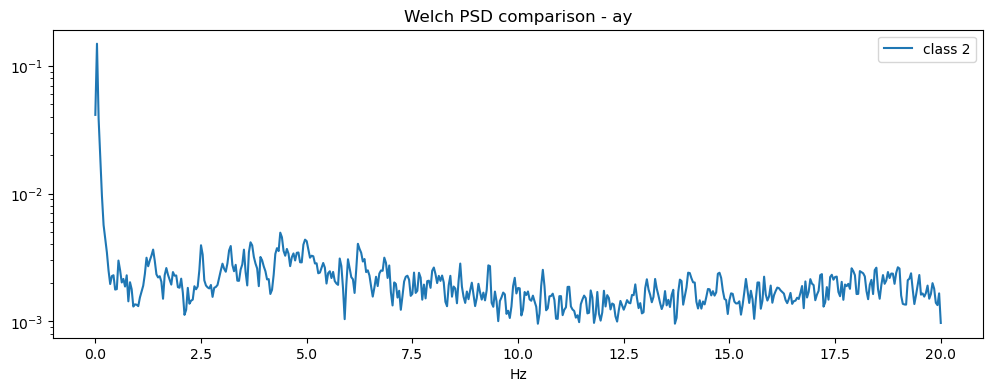

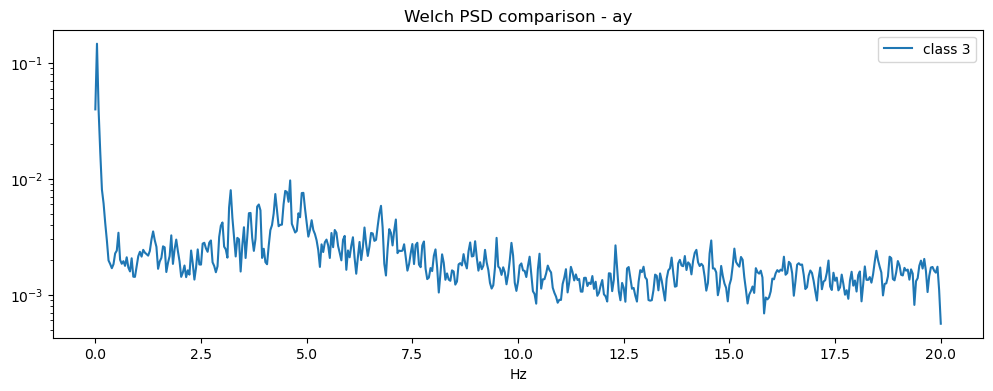

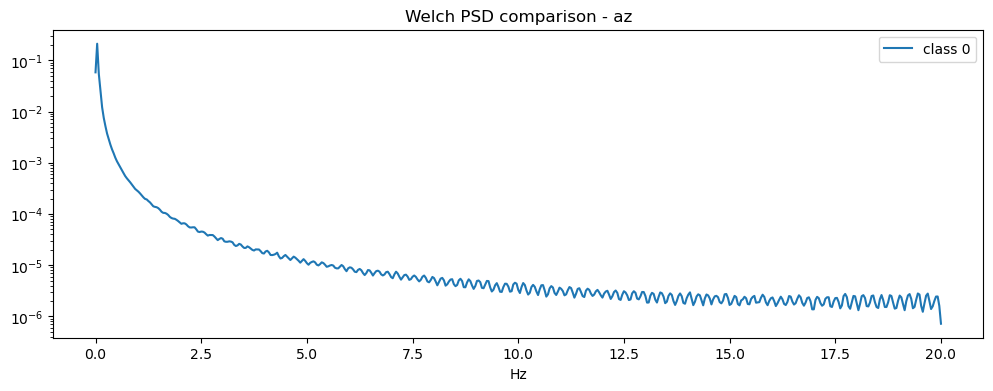

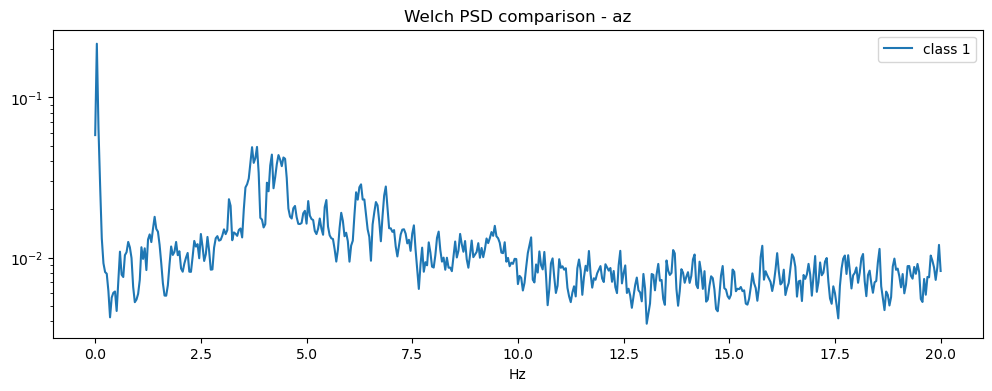

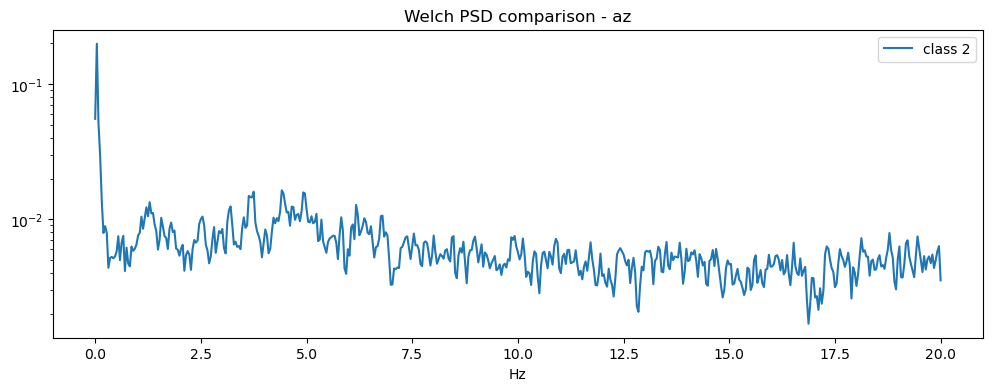

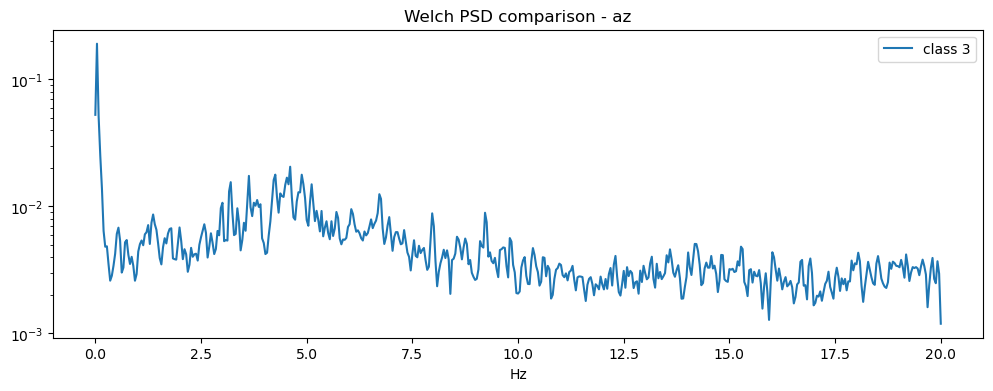

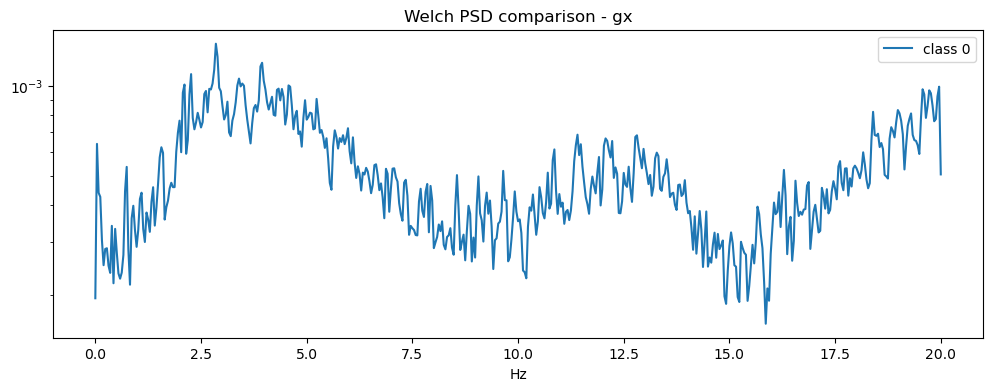

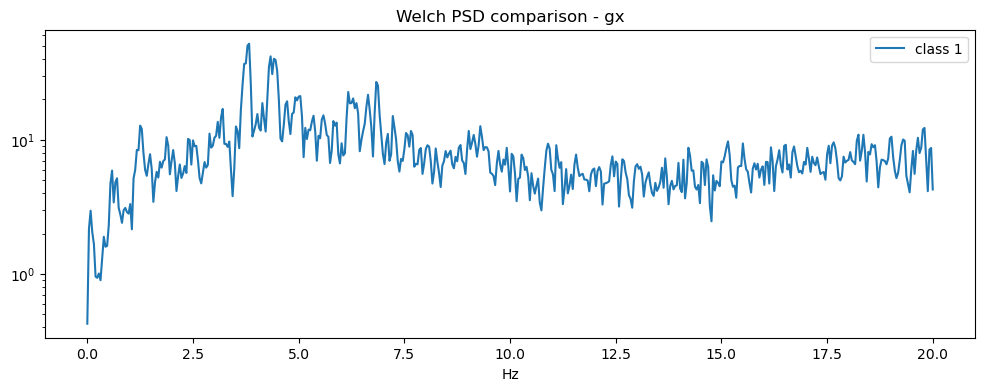

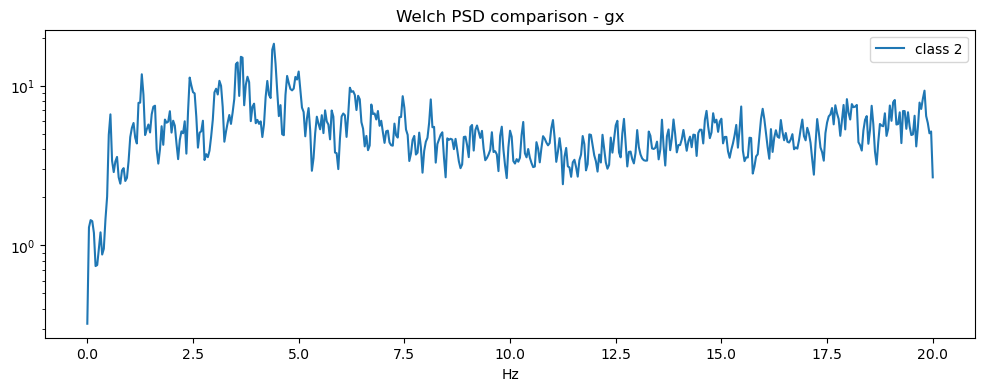

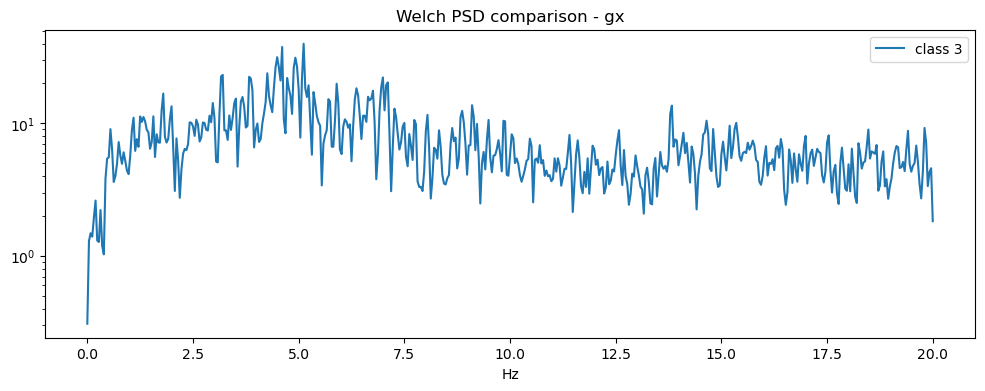

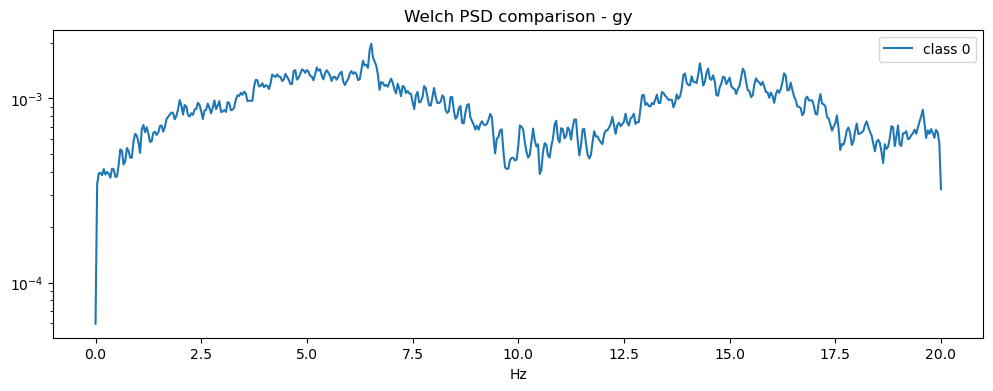

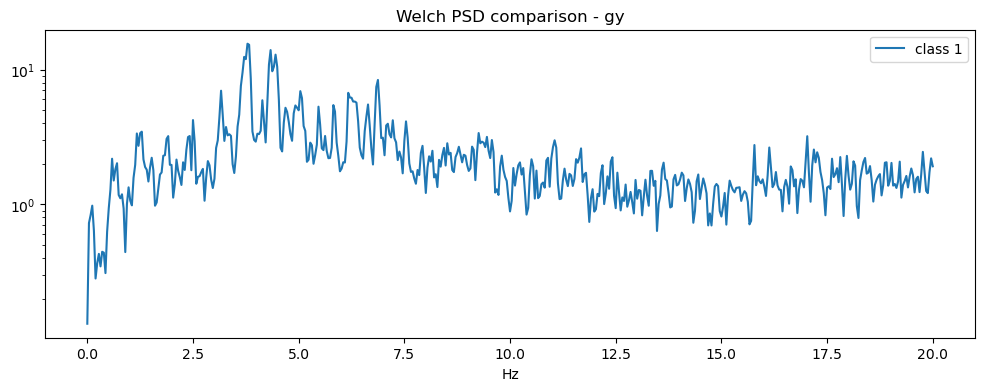

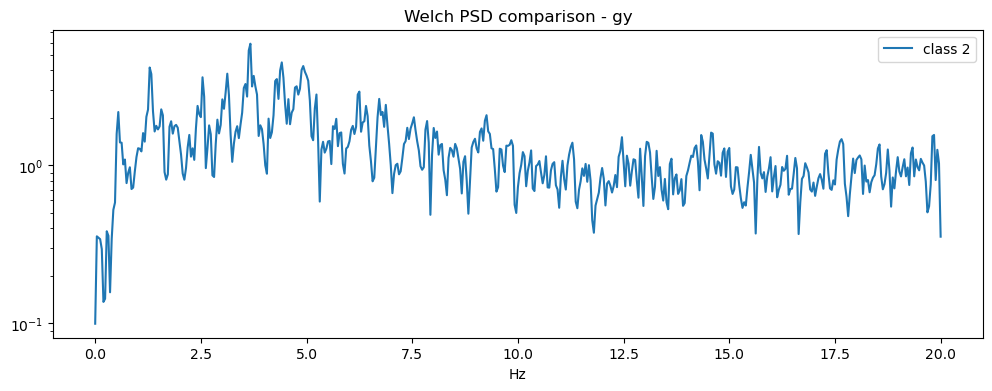

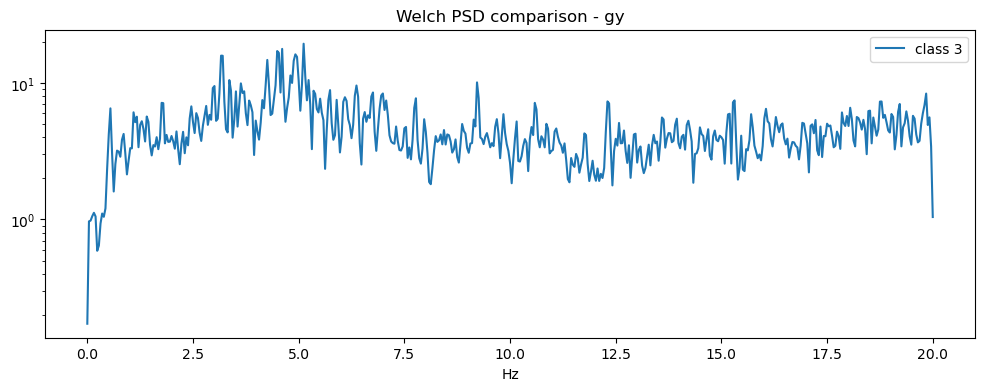

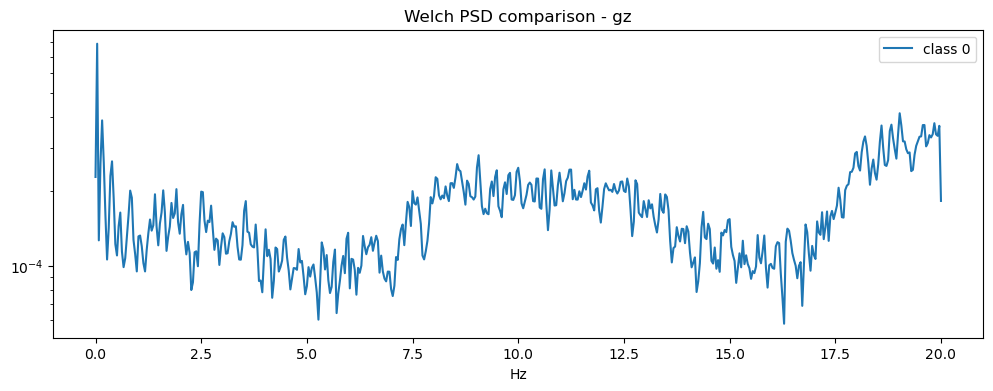

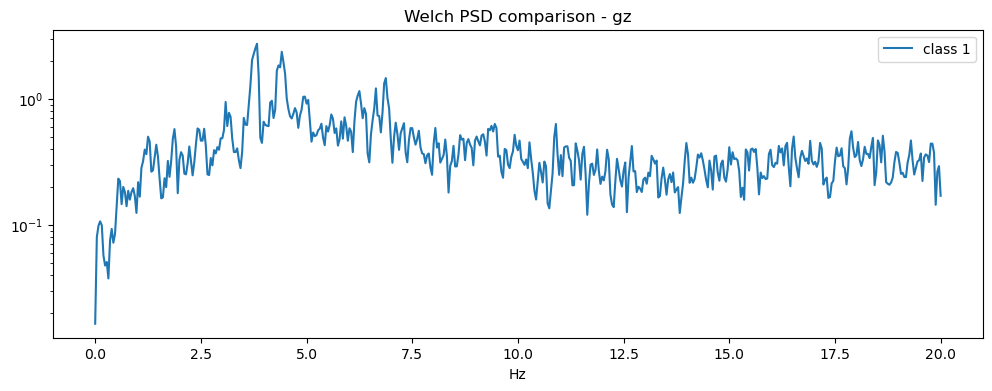

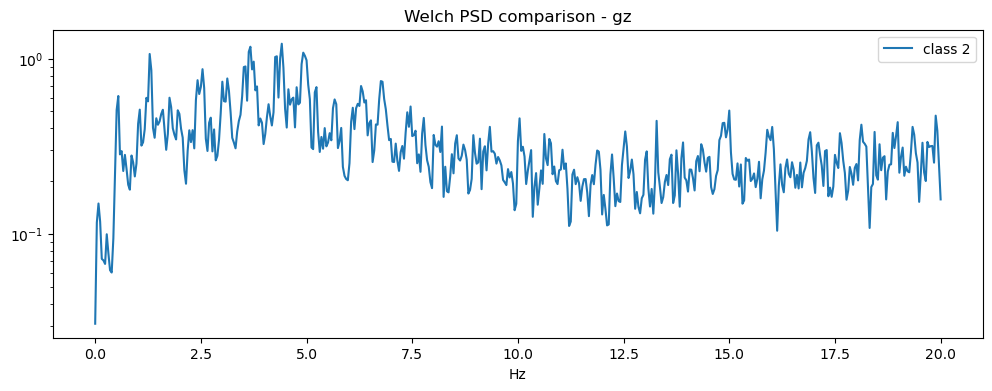

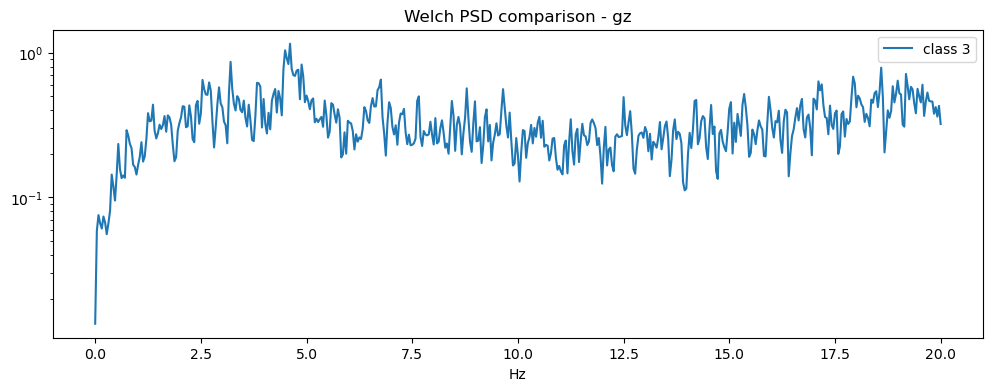

In [113]:
def plot_welch_for_class(df_class, sensor_col, fs, nperseg=512):
    f, Pxx = welch(df_class[sensor_col].values, fs = fs, nperseg=nperseg)
    plt.semilogy(f, Pxx)
    plt.xlabel('Frequency (Hz)'); plt.ylabel('PSD'); plt.title(f'Welch PSD - class {df_class[label_column].iloc[0]} - {sensor_col}')

for col in data_columns:
    plt.figure()

    for lab in unique_labels:
        sub = df[df[label_column]==lab]
        
        # use a reasonable subset for speed
        sub_small = sub[col].dropna().values[:16000]
        if len(sub_small) < 128:
            continue
        f, Pxx = welch(sub_small, fs, nperseg=1024)
        plt.semilogy(f, Pxx, label = f'class {lab}')
        plt.legend(); plt.xlabel('Hz'); plt.title(f'Welch PSD comparison - {col}'); plt.show()

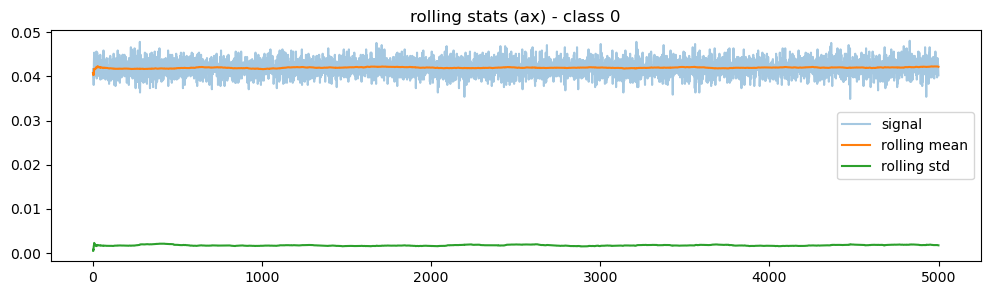

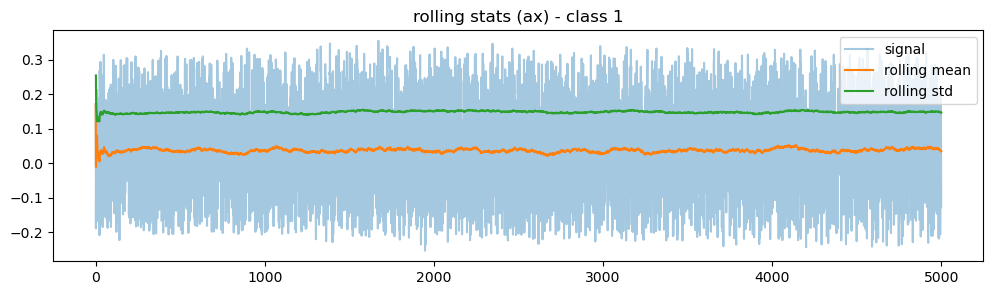

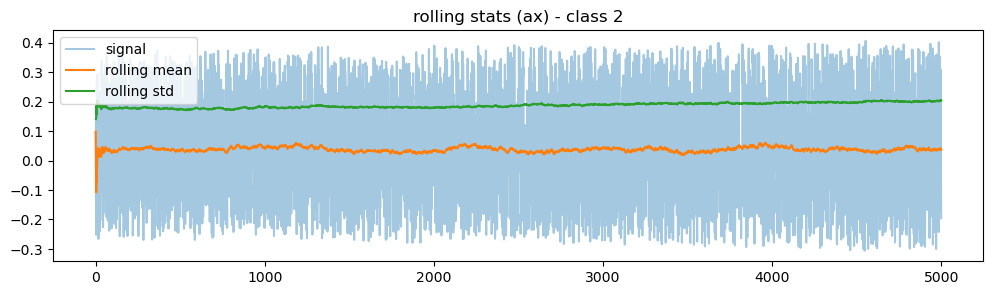

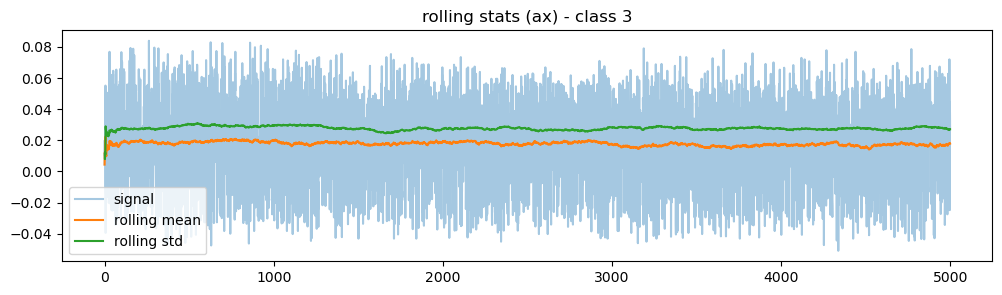

In [137]:
#rolling statistics
window = int(fs * 5) # 5-second rolling window

for lab in unique_labels:
    sub = df[df[label_column] == lab]
    if len(sub) < window:
        continue
    roll_mean = sub['ax'].rolling(window = window, min_periods=1).mean()
    roll_std = sub['ax'].rolling(window = window, min_periods=1).std()
    plt.figure(figsize=(12,3))
    plt.plot(sub['ax'].values[:5000], alpha = 0.4, label='signal')
    plt.plot(roll_mean.values[:5000], label = 'rolling mean')
    plt.plot(roll_std.values[:5000], label = 'rolling std')
    plt.title(f'rolling stats (ax) - class {lab}'); plt.legend(); plt.show()

In [147]:
# spectral entropy (a measure of signal irregularity)

def spectral_entropy(x, fs = fs, nperseg = 256):
    f, Pxx = welch(x, fs = fs, nperseg = nperseg)
    Pxx_norm = Pxx / np.sum(Pxx)
    se = -np.sum(Pxx_norm * np.log(Pxx_norm + 1e-12))
    return se


for lab in unique_labels:
    sub = df[df[label_column] == lab]
    if len(sub) < 1024:
        continue
    se_ax = spectral_entropy(sub['ax'].values[:4096])
    print(f'Class {lab} spectral entropy (ax): {se_ax:.4f}')

Class 0 spectral entropy (ax): 4.8151
Class 1 spectral entropy (ax): 4.7139
Class 2 spectral entropy (ax): 4.7356
Class 3 spectral entropy (ax): 4.7790


embedding matrix shape: (400, 1536)


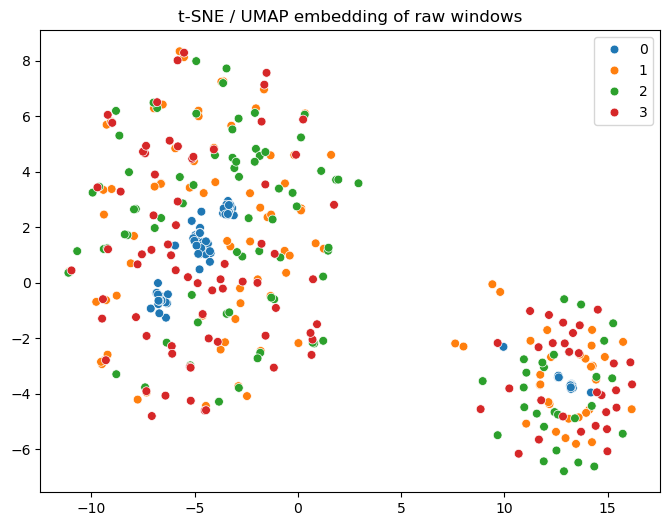

In [155]:
# t-SNE / UMAP embedding of short windows to inspect separability by forming windows (non-overlapping) of size 256 for embedding

try:
    import umap
    _HAS_UMAP = True
except Exception:
    _HAS_UMAP = False


W = 256

sample_per_class = 100 # windows per class for embedding
windows = []
labels_emb = []

for lab in unique_labels:
    sub = df[df[label_column] == lab]
    n_windows = min(sample_per_class, len(sub)//W)
    
    for i in range(n_windows):
        start = i * W
        win = sub[data_columns].values[start:start+W]
        
        # flatten
        windows.append(win.flatten())
        labels_emb.append(lab)

X_emb = np.array(windows)
print('embedding matrix shape:', X_emb.shape)


if X_emb.shape[0] >= 3:
    if _HAS_UMAP:
        reducer = umap.UMAP(n_components = 2, random_state = 42)
        emb = reducer.fit_transform(X_emb)
    else:
        emb = TSNE(n_components = 2, random_state = 42, init = 'pca', perplexity = 30).fit_transform(X_emb)
        plt.figure(figsize = (8,6))
        sns.scatterplot(x = emb[:,0], y = emb[:,1], hue = labels_emb, palette = 'tab10', s = 40)
        plt.title('t-SNE / UMAP embedding of raw windows'); plt.show()
else:
    print('Not enough windows for embedding.');

### permutation / sanity check

CV Accuracy: 0.659 ± 0.017


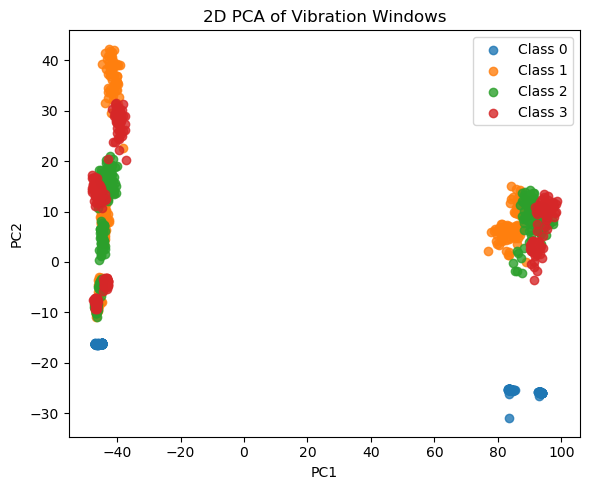

In [169]:
# PCA + Logistic Regression Baseline
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt

# 1) Reload & re-segment (non-overlap)
files = {
    'motor_off': 'motor_off.xlsx',
    'motor_on': 'motor_on.xlsx',
    'motor_on_nofan': 'motor_on_nofan.xlsx',
    'motor_on_badfan': 'motor_on_badfan.xlsx'
}
dataframes = {label: pd.read_excel(path) for label, path in files.items()}

def segment_signal(df, window_size=100, step_size=100):
    segs, labs = [], []
    for start in range(0, len(df) - window_size + 1, step_size):
        seg = df[['ax','ay','az']].iloc[start:start+window_size].values.T
        segs.append(seg)
        labs.append(df['class_label'].iloc[start])
    return np.array(segs), np.array(labs)

# gather all segments and labels
segments_list, labels_list = [], []
for df in dataframes.values():
    s, l = segment_signal(df)
    segments_list.append(s)
    labels_list.append(l)
segments_all = np.concatenate(segments_list, axis=0)
labels_all   = np.concatenate(labels_list, axis=0)

# 2) Feature extraction (including vector magnitude)
def extract_features_with_magnitude(segs, fft_bins=50, roll_win=10):
    feats = []
    for x, y, z in segs:
        def axis_feats(sig):
            vals = np.abs(fft(sig))[:fft_bins]
            m, s, mn, mx = sig.mean(), sig.std(), sig.min(), sig.max()
            sk, kt = skew(sig), kurtosis(sig)
            rv = pd.Series(sig).rolling(roll_win).var().dropna()
            rv_m, rv_s = rv.mean(), rv.std()
            return np.hstack([vals, m, s, mn, mx, sk, kt, vals.mean(), vals.std(), rv_m, rv_s])
        x_f, y_f, z_f = axis_feats(x), axis_feats(y), axis_feats(z)
        acc = np.sqrt(x**2 + y**2 + z**2)
        a_vals = np.abs(fft(acc))[:fft_bins]
        a_stats = [acc.mean(), acc.std(), acc.min(), acc.max(), skew(acc), kurtosis(acc)]
        a_rv = pd.Series(acc).rolling(roll_win).var().dropna()
        a_feats = np.hstack([a_vals, *a_stats, a_vals.mean(), a_vals.std(), a_rv.mean(), a_rv.std()])
        feats.append(np.hstack([x_f, y_f, z_f, a_feats]))
    return np.array(feats)

features_all = extract_features_with_magnitude(segments_all)

# 3) PCA to 10 components for modeling
pca = PCA(n_components=10, random_state=42)
X_pca = pca.fit_transform(features_all)

# 4) Logistic Regression with 5-fold Stratified CV
clf = LogisticRegression(max_iter=1000, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_pca, labels_all, cv=cv, scoring='accuracy')
print(f"CV Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# 5) PCA to 2 components for scatter plot
pca2 = PCA(n_components=2, random_state=42)
X_vis = pca2.fit_transform(features_all)
df_vis = pd.DataFrame(X_vis, columns=['PC1','PC2'])
df_vis['label'] = labels_all

plt.figure(figsize=(6,5))
for lbl in sorted(df_vis['label'].unique()):
    subset = df_vis[df_vis['label']==lbl]
    plt.scatter(subset['PC1'], subset['PC2'], label=f'Class {lbl}', alpha=0.8)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('2D PCA of Vibration Windows')
plt.legend()
plt.tight_layout()
plt.show()